# Lab 12: Spark MLlib tutorials

In this class, we will walk through Spark MLlib section. 

> You can refer to the [official documentation for Spark MLlib](https://spark.apache.org/docs/latest/ml-guide.html) for more details and examples. 

-----


In [1]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
import pyspark.sql.functions as F
from pyspark import SparkConf

import os 
os.environ['PYSPARK_PYTHON'] = "/root/anaconda3/bin/python"

spark = SparkSession.builder.config("spark.log.level", "WARN") \
  .appName("lab12_exercise").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 11:34:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting Spark log level to "WARN".
24/05/11 11:34:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Part 1: Data Cleansing with Airbnb

We will use the SF Airbnb rental dataset in `/shareddata/data/sf-airbnb`.

In [2]:
filePath = "/shareddata/data/sf-airbnb/sf-airbnb.csv"

rawDF = spark.read.csv(filePath, header="true", inferSchema="true", multiLine="true", escape='"')

rawDF.select('id', 'space').show(5)
rawDF.printSchema()

+----+--------------------+
|  id|               space|
+----+--------------------+
| 958|Newly remodeled, ...|
|5858|We live in a larg...|
|7918|Room rental-sunny...|
|8142|Room rental Sunny...|
|8339|Please send us a ...|
+----+--------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: long (nullable = true)
 |-- last_scraped: date (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_

For the sake of simplicity, only keep certain columns from this dataset. We will talk about feature selection later.

In [3]:
columnsToKeep = [
  "host_is_superhost",
  "cancellation_policy",
  "instant_bookable",
  "host_total_listings_count",
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "property_type",
  "room_type",
  "accommodates",
  "bathrooms",
  "bedrooms",
  "beds",
  "bed_type",
  "minimum_nights",
  "number_of_reviews",
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "price"]

baseDF = rawDF.select(columnsToKeep)
baseDF.cache().count()
baseDF.show(5)

+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-------+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|  price|
+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+-------

## Fixing Data Types

Take a look at the schema above. You'll notice that the `price` field got picked up as string. For our task, we need it to be a numeric (double type) field. 


In [4]:
from pyspark.sql.functions import col, translate

fixedPriceDF = baseDF.withColumn("price", translate(col("price"), "$,", "").cast("double"))

fixedPriceDF.show(5)

+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|price|
+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+--

In [5]:
fixedPriceDF.describe()

DataFrame[summary: string, host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: string, neighbourhood_cleansed: string, latitude: string, longitude: string, property_type: string, room_type: string, accommodates: string, bathrooms: string, bedrooms: string, beds: string, bed_type: string, minimum_nights: string, number_of_reviews: string, review_scores_rating: string, review_scores_accuracy: string, review_scores_cleanliness: string, review_scores_checkin: string, review_scores_communication: string, review_scores_location: string, review_scores_value: string, price: string]

In [6]:
fixedPriceDF.summary()

DataFrame[summary: string, host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: string, neighbourhood_cleansed: string, latitude: string, longitude: string, property_type: string, room_type: string, accommodates: string, bathrooms: string, bedrooms: string, beds: string, bed_type: string, minimum_nights: string, number_of_reviews: string, review_scores_rating: string, review_scores_accuracy: string, review_scores_cleanliness: string, review_scores_checkin: string, review_scores_communication: string, review_scores_location: string, review_scores_value: string, price: string]

## Nulls

There are a lot of different ways to handle null values. Sometimes, null can actually be a key indicator of the thing you are trying to predict (e.g. if you don't fill in certain portions of a form, probability of it getting approved decreases).

Some ways to handle nulls:
* Drop any records that contain nulls
* Numeric:
  * Replace them with mean/median/zero/etc.
* Categorical:
  * Replace them with the mode
  * Create a special category for null
* Use techniques like ALS which are designed to impute missing values
  
**If you do ANY imputation techniques for categorical/numerical features, you MUST include an additional field specifying that field was imputed (think about why this is necessary)**

There are a few nulls in the categorical feature `host_is_superhost`. Let's get rid of those rows where any of these columns is null.

SparkML's Imputer (will cover below) does not support imputation for categorical features, so this is the simplest approach for the time being.

In [7]:
noNullsDF = fixedPriceDF.na.drop(subset=["host_is_superhost"])

## Impute: Cast to Double

SparkML's `Imputer` requires all fields be of type double [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.Imputer)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.Imputer). Let's cast all integer fields to double.

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

integerColumns = [x.name for x in baseDF.schema.fields if x.dataType == IntegerType()]
doublesDF = noNullsDF

for c in integerColumns:
  doublesDF = doublesDF.withColumn(c, col(c).cast("double"))

columns = "\n - ".join(integerColumns)
print(f"Columns converted from Integer to Double:\n - {columns}")

Columns converted from Integer to Double:
 - host_total_listings_count
 - accommodates
 - bedrooms
 - beds
 - minimum_nights
 - number_of_reviews
 - review_scores_rating
 - review_scores_accuracy
 - review_scores_cleanliness
 - review_scores_checkin
 - review_scores_communication
 - review_scores_location
 - review_scores_value


Add in dummy variable if we will impute any value.

In [9]:
from pyspark.sql.functions import when

imputeCols = [
  "bedrooms",
  "bathrooms",
  "beds", 
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value"
]

for c in imputeCols:
  doublesDF = doublesDF.withColumn(c + "_na", when(col(c).isNull(), 1.0).otherwise(0.0))

In [10]:
doublesDF.describe()

DataFrame[summary: string, host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: string, neighbourhood_cleansed: string, latitude: string, longitude: string, property_type: string, room_type: string, accommodates: string, bathrooms: string, bedrooms: string, beds: string, bed_type: string, minimum_nights: string, number_of_reviews: string, review_scores_rating: string, review_scores_accuracy: string, review_scores_cleanliness: string, review_scores_checkin: string, review_scores_communication: string, review_scores_location: string, review_scores_value: string, price: string, bedrooms_na: string, bathrooms_na: string, beds_na: string, review_scores_rating_na: string, review_scores_accuracy_na: string, review_scores_cleanliness_na: string, review_scores_checkin_na: string, review_scores_communication_na: string, review_scores_location_na: string, review_scores_value_na: string]

In [11]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy="median", inputCols=imputeCols, outputCols=imputeCols)

imputedDF = imputer.fit(doublesDF).transform(doublesDF)

#### Getting rid of extreme values

Let's take a look at the *min* and *max* values of the `price` column:

In [12]:
imputedDF.select("price").describe().show(5)

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              7151|
|   mean| 213.6540344007831|
| stddev|313.28222046853125|
|    min|               0.0|
|    max|           10000.0|
+-------+------------------+



There are some super-expensive listings. But that's the Data Scientist's job to decide what to do with them. We can certainly filter the "free" Airbnbs though.

Let's see first how many listings we can find where the *price* is zero.

In [13]:
imputedDF.filter(col("price") == 0).count()

1

Now only keep rows with a strictly positive *price*.

In [14]:
posPricesDF = imputedDF.filter(col("price") > 0)

Let's take a look at the *min* and *max* values of the *minimum_nights* column:

In [15]:
posPricesDF.select("minimum_nights").describe().show(5)

+-------+------------------+
|summary|    minimum_nights|
+-------+------------------+
|  count|              7150|
|   mean| 14002.25986013986|
| stddev|1182624.6002248244|
|    min|               1.0|
|    max|             1.0E8|
+-------+------------------+



In [16]:
(posPricesDF
  .groupBy("minimum_nights").count()
  .orderBy(col("count").desc(), col("minimum_nights"))).show(5)

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|          30.0| 2757|
|           2.0| 1455|
|           1.0| 1251|
|           3.0|  822|
|           4.0|  270|
+--------------+-----+
only showing top 5 rows



A minimum stay of one year seems to be a reasonable limit here. Let's filter out those records where the *minimum_nights* is greater then 365:

In [17]:
cleanDF = posPricesDF.filter(col("minimum_nights") <= 365)

cleanDF.show(5)

24/05/11 11:35:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|

OK, our data is cleansed now. Let's save this DataFrame to a file so that we can start building models with it.

In [18]:
outputPath = "/tmp/sf-airbnb/sf-airbnb-clean.parquet"

cleanDF.write.mode("overwrite").parquet(outputPath)


# Part 2: Regression: Predicting Rental Price


## Train/Test Split

When we are building ML models, we don't want to look at our test data. 

Let's keep 80% for the training set and set aside 20% of our data for the test set. We will use the `randomSplit` method [Python](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit).

**Question**: Why is it necessary to set a seed?

In [19]:
airbnbDF = cleanDF
trainDF, testDF = airbnbDF.randomSplit([.8, .2], seed=42)
print(f"There are {trainDF.cache().count()} rows in the training set, and {testDF.cache().count()} in the test set")

There are 5780 rows in the training set, and 1366 in the test set



**Question**: What happens if you change your cluster configuration?

To test this out, try spinning up a cluster with just one worker, and another with two workers. 

> NOTE: This data is quite small (one partition), and you will need to test it out with a larger dataset (e.g. 2+ partitions) to see the difference, such as: `/shareddata/data/sf-airbnb/sf-airbnb-clean-100p.parquet.` However, in this code below, we will simply repartition our data to simulate how it could have been partitioned differently on a different cluster configuration, and see if we get the same number of data points in our training set. 

In [20]:
(trainRepartitionDF, testRepartitionDF) = (airbnbDF
                                           .repartition(24)
                                           .randomSplit([.8, .2], seed=42))

print(trainRepartitionDF.count())

5738


When you do an 80/20 train/test split, it is an "approximate" 80/20 split. It is not an exact 80/20 split, and when we the partitioning of our data changes, we show that we get not only a different # of data points in train/test, but also different data points.

Our recommendation is to split your data once, then write it out to its own train/test folder so you don't have these reproducibility issues.

We are going to build a very simple linear regression model predicting `price` just given the number of `bedrooms`.

**Question**: What are some assumptions of the linear regression model?

In [21]:
trainDF.select("price", "bedrooms").summary()

DataFrame[summary: string, price: string, bedrooms: string]

There do appear some outliers in our dataset for the price ($10,000 a night??). Just keep this in mind when we are building our models :).

## Vector Assembler

Linear Regression expects a column of Vector type as input.

We can easily get the values from the `bedrooms` column into a single vector using `VectorAssembler` [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.VectorAssembler). VectorAssembler is an example of a **transformer**. Transformers take in a DataFrame, and return a new DataFrame with one or more columns appended to it. They do not learn from your data, but apply rule based transformations.

In [22]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")

vecTrainDF = vecAssembler.transform(trainDF)

vecTrainDF.select("bedrooms", "features", "price").show(10)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]| 95.0|
|     1.0|   [1.0]|250.0|
|     3.0|   [3.0]|250.0|
|     1.0|   [1.0]|115.0|
|     1.0|   [1.0]|105.0|
|     1.0|   [1.0]| 86.0|
|     1.0|   [1.0]|100.0|
|     2.0|   [2.0]|220.0|
+--------+--------+-----+
only showing top 10 rows



## Linear Regression

Now that we have prepared our data, we can use the `LinearRegression` estimator to build our first model [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.regression.LinearRegression). Estimators accept a DataFrame as input and return a model, and have a `.fit()` method. 

In [23]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="price")
lrModel = lr.fit(vecTrainDF)

24/05/11 11:35:12 WARN Instrumentation: [ecc907b5] regParam is zero, which might cause numerical instability and overfitting.
24/05/11 11:35:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/11 11:35:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## Inspect the model

In [24]:
m = round(lrModel.coefficients[0], 2)
b = round(lrModel.intercept, 2)

print(f"The formula for the linear regression line is price = {m}*bedrooms + {b}")

The formula for the linear regression line is price = 123.68*bedrooms + 47.51


## Pipeline

In [25]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

24/05/11 11:35:13 WARN Instrumentation: [3500b001] regParam is zero, which might cause numerical instability and overfitting.


## Apply to Test Set

In [26]:
predDF = pipelineModel.transform(testDF)

predDF.select("bedrooms", "features", "price", "prediction").show(10)


+--------+--------+------+------------------+
|bedrooms|features| price|        prediction|
+--------+--------+------+------------------+
|     1.0|   [1.0]|  85.0|171.18598011578285|
|     1.0|   [1.0]|  45.0|171.18598011578285|
|     1.0|   [1.0]|  70.0|171.18598011578285|
|     1.0|   [1.0]| 128.0|171.18598011578285|
|     1.0|   [1.0]| 159.0|171.18598011578285|
|     2.0|   [2.0]| 250.0|294.86172649777757|
|     1.0|   [1.0]|  99.0|171.18598011578285|
|     1.0|   [1.0]|  95.0|171.18598011578285|
|     1.0|   [1.0]| 100.0|171.18598011578285|
|     1.0|   [1.0]|2010.0|171.18598011578285|
+--------+--------+------+------------------+
only showing top 10 rows



# Part 3: Baseline Model

Let's compute the average `price` on the training dataset, and use that as our prediction column for our test dataset, then evaluate the result.

In [27]:
from pyspark.sql.functions import avg, lit

# filePath = "/tmp/sf-airbnb/sf-airbnb-clean.parquet"
# airbnbDF = spark.read.parquet(filePath)
trainDF, testDF = airbnbDF.randomSplit([.8, .2], seed=42)

avgPrice = float(trainDF.select(avg("price")).first()[0])
predDF = testDF.withColumn("avgPrediction", lit(avgPrice))

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionMeanEvaluator = RegressionEvaluator(predictionCol="avgPrediction", labelCol="price", metricName="rmse")

print(f"The RMSE for predicting the average price is: {regressionMeanEvaluator.evaluate(predDF):.2f}")


The RMSE for predicting the average price is: 240.71


# Part 4: One-Hot Encoding

## Train/Test Split

Let's use the same 80/20 split with the same seed as the previous notebook so we can compare our results apples to apples (unless you changed the cluster config!)

In [29]:
trainDF, testDF = airbnbDF.randomSplit([.8, .2], seed=42)

## Option 1: StringIndexer, OneHotEncoder, and VectorAssembler

Here, we are going to One Hot Encode (OHE) our categorical variables. The first approach we are going to use will combine StringIndexer, OneHotEncoder, and VectorAssembler.

First we need to use `StringIndexer` to map a string column of labels to an ML column of label indices [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.StringIndexer).

Then, we can apply the `OneHotEncoder` to the output of the StringIndexer [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.OneHotEncoder).

In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

categoricalCols = [field for (field, dataType) in trainDF.dtypes 
                   if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, 
                              outputCols=indexOutputCols, 
                              handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols, 
                           outputCols=oheOutputCols)

Now we can combine our OHE categorical features with our numeric features.

In [31]:
from pyspark.ml.feature import VectorAssembler

numericCols = [field for (field, dataType) in trainDF.dtypes 
               if ((dataType == "double") & (field != "price"))]

assemblerInputs = oheOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs, 
                               outputCol="features")

## Option 2: RFormula
Instead of manually specifying which columns are categorical to the StringIndexer and OneHotEncoder, RFormula can do that automatically for you [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.RFormula)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.RFormula).

With RFormula, if you have any columns of type String, it treats it as a categorical feature and string indexes & one hot encodes it for us. Otherwise, it leaves as it is. Then it combines all of one-hot encoded features and numeric features into a single vector, called `features`.

In [32]:
from pyspark.ml.feature import RFormula

rFormula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip")

## Linear Regression

Now that we have all of our features, let's build a linear regression model.

In [33]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="price", featuresCol="features")

## Pipeline

Let's put all these stages in a Pipeline. A `Pipeline` is a way of organizing all of our transformers and estimators [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.Pipeline).

Verify you get the same results with Option 1 (StringIndexer, OneHotEncoderEstimator, and VectorAssembler) and Option 2 (RFormula)

In [34]:
# Option 1: StringIndexer + OHE + VectorAssembler
from pyspark.ml import Pipeline

stages = [stringIndexer, oheEncoder, vecAssembler, lr]
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "price", "prediction").show(5)

24/05/11 11:35:15 WARN Instrumentation: [27e79b91] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(98,[0,3,6,22,43,...| 85.0| 55.24365707389188|
|(98,[0,3,6,22,43,...| 45.0|23.357685914717877|
|(98,[0,3,6,22,43,...| 70.0|28.474464479034395|
|(98,[0,3,6,12,42,...|128.0| -91.6079079594947|
|(98,[0,3,6,12,43,...|159.0| 95.05688229945372|
+--------------------+-----+------------------+
only showing top 5 rows



In [35]:
# Option 2: RFormula
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [rFormula, lr])

pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "price", "prediction").show(5)

24/05/11 11:35:18 WARN Instrumentation: [28119935] regParam is zero, which might cause numerical instability and overfitting.
24/05/11 11:35:18 WARN Instrumentation: [28119935] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(98,[0,3,6,7,23,4...| 85.0| 55.40518338251741|
|(98,[0,3,6,7,23,4...| 45.0|22.558643930734434|
|(98,[0,3,6,7,23,4...| 70.0|27.035891181432817|
|(98,[0,3,6,7,13,4...|128.0|-91.29310091873367|
|(98,[0,3,6,7,13,4...|159.0| 94.66473870534765|
+--------------------+-----+------------------+
only showing top 5 rows



## Evaluate Model: RMSE

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")

rmse = round(regressionEvaluator.evaluate(predDF), 2)
print(f"RMSE is {rmse}")

RMSE is 220.69


## R2


In [37]:
r2 = round(regressionEvaluator.setMetricName("r2").evaluate(predDF), 2)
print(f"R2 is {r2}")

R2 is 0.16


In [38]:
pipelinePath = "/tmp/sf-airbnb/lr-pipeline-model"
pipelineModel.write().overwrite().save(pipelinePath)

## Loading models

When you load in models, you need to know the type of model you are loading back in (was it a linear regression or logistic regression model?).

For this reason, we recommend you always put your transformers/estimators into a Pipeline, so you can always load the generic PipelineModel back in.

In [39]:
from pyspark.ml import PipelineModel

savedPipelineModel = PipelineModel.load(pipelinePath)

## Distributed Setting

If you are interested in learning how linear regression is implemented in the distributed setting and bottlenecks, check out these lecture slides:
* [distributed-linear-regression-1](https://files.training.databricks.com/static/docs/distributed-linear-regression-1.pdf)
* [distributed-linear-regression-2](https://files.training.databricks.com/static/docs/distributed-linear-regression-2.pdf)


# Part 5: Log Scale

In this part, you will improve your model performance by transforming the label to log scale, predicting on log scale, then exponentiating to evaluate the result. 

In [40]:
# filePath = "/tmp/sf-airbnb/sf-airbnb-clean.parquet"
# airbnbDF = spark.read.parquet(filePath)
(trainDF, testDF) = airbnbDF.randomSplit([.8, .2], seed=42)

In [41]:
from pyspark.sql.functions import col, log
from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import LinearRegression

logTrainDF = trainDF.withColumn("log_price", log(col("price")))
logTestDF = testDF.withColumn("log_price", log(col("price")))

rFormula = RFormula(formula="log_price ~ . - price", featuresCol="features", labelCol="log_price", handleInvalid="skip") 

lr = LinearRegression(labelCol="log_price", predictionCol="log_pred")
pipeline = Pipeline(stages = [rFormula, lr])
pipelineModel = pipeline.fit(logTrainDF)
predDF = pipelineModel.transform(logTestDF)

24/05/11 11:35:29 WARN Instrumentation: [c49115fd] regParam is zero, which might cause numerical instability and overfitting.
24/05/11 11:35:30 WARN Instrumentation: [c49115fd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Exponentiate

In order to interpret our RMSE, we need to convert our predictions back from logarithmic scale.

In [42]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, exp

expDF = predDF.withColumn("prediction", exp(col("log_pred")))

regressionEvaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
rmse = regressionEvaluator.setMetricName("rmse").evaluate(expDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(expDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")


RMSE is 208.41093081345025
R2 is 0.25039912467770375


# Part 6: Decision Trees

In this part, we're going to try tree based methods and see if our performance improves.

In [43]:
# filePath = "/tmp/sf-airbnb/sf-airbnb-clean.parquet"
# airbnbDF = spark.read.parquet(filePath)
trainDF, testDF = airbnbDF.randomSplit([.8, .2], seed=42)

## How to Handle Categorical Features?

We can use StringIndexer/OneHotEncoderEstimator/VectorAssembler or RFormula.

**However, for decision trees, and in particular, random forests, we should not OHE our variables.**

Why is that? Well, how the splits are made is different (you can see this when you visualize the tree) and the feature importance scores are not correct.

For random forests (which we will discuss shortly), the result can change dramatically. So instead of using RFormula, we are going to use just StringIndexer/VectorAssembler.

In [44]:
from pyspark.ml.feature import StringIndexer

categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")

## VectorAssembler

Let's use the VectorAssembler to combine all of our categorical and numeric inputs [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.feature.VectorAssembler).

In [45]:
from pyspark.ml.feature import VectorAssembler

# Filter for just numeric columns (and exclude price, our label)
numericCols = [field for (field, dataType) in trainDF.dtypes 
               if ((dataType == "double") & (field != "price"))]
# Combine output of StringIndexer defined above and numeric columns
assemblerInputs = indexOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

## Decision Tree

Now let's build a `DecisionTreeRegressor` with the default hyperparameters [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.regression.DecisionTreeRegressor).

In [46]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol="price")

## Fit Pipeline

In [47]:
from pyspark.ml import Pipeline

# Combine stages into pipeline
stages = [stringIndexer, vecAssembler, dt]
pipeline = Pipeline(stages=stages)

# Uncomment to perform fit
# pipelineModel = pipeline.fit(trainDF)

## maxBins

What is this parameter [maxBins](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor.maxBins)? Let's take a look at the PLANET implementation of distributed decision trees (which Spark uses) and compare it to this paper called [Yggdrasil](https://cs.stanford.edu/~matei/papers/2016/nips_yggdrasil.pdf) by Matei Zaharia and others. This will help explain the `maxBins` parameter.


<img src="https://files.training.databricks.com/images/DistDecisionTrees.png" height=500px>

In Spark, data is partitioned by row. So when it needs to make a split, each worker has to compute summary statistics for every feature for  each split point. Then these summary statistics have to be aggregated (via tree reduce) for a split to be made.

Think about it: What if worker 1 had the value `32` but none of the others had it. How could you communicate how good of a split that would be? So, Spark has a maxBins parameter for discretizing continuous variables into buckets, but the number of buckets has to be as large as the number of categorical variables.

Let's go ahead and increase maxBins to `40`.

In [48]:
dt.setMaxBins(40)

DecisionTreeRegressor_73bf61cbbac7

Take two.

In [49]:
pipelineModel = pipeline.fit(trainDF)

## Visualize the Decision Tree

In [50]:
dtModel = pipelineModel.stages[-1]
print(dtModel.toDebugString)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_73bf61cbbac7, depth=5, numNodes=47, numFeatures=33
  If (feature 12 <= 2.5)
   If (feature 12 <= 1.5)
    If (feature 5 in {1.0,2.0})
     If (feature 4 in {0.0,1.0,3.0,5.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,24.0})
      If (feature 3 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0})
       Predict: 104.23992784125075
      Else (feature 3 not in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0})
       Predict: 250.7111111111111
     Else (feature 4 not in {0.0,1.0,3.0,5.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,24.0})
      If (feature 3 in {0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,27.0,33.0,35.0})
       Predict: 151.94179894179894
      Else (feat

## Feature Importance

Let's go ahead and get the fitted decision tree model, and look at the feature importance scores.

In [51]:
dtModel = pipelineModel.stages[-1]
dtModel.featureImportances

SparseVector(33, {1: 0.1679, 2: 0.1401, 3: 0.0562, 4: 0.1282, 5: 0.0109, 9: 0.0388, 10: 0.0036, 12: 0.2834, 13: 0.0152, 14: 0.0295, 15: 0.1262})

## Interpreting Feature Importance

It's a little hard to know what feature 4 vs 11 is. Given that the feature importance scores are "small data", let's use Pandas to help us recover the original column names.

In [52]:
import pandas as pd
dtModel = pipelineModel.stages[-1]
featureImp = pd.DataFrame(
  list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)),
  columns=["feature", "importance"])
featureImp.sort_values(by="importance", ascending=False)

,feature,importance
12,bedrooms,0.283406
1,cancellation_policyIndex,0.167893
2,instant_bookableIndex,0.140081
4,property_typeIndex,0.128179
15,number_of_reviews,0.126233
3,neighbourhood_cleansedIndex,0.056200
9,longitude,0.038810
14,minimum_nights,0.029473
13,beds,0.015218
5,room_typeIndex,0.010905


## Apply model to test set

In [53]:
predDF = pipelineModel.transform(testDF)

predDF.select("features", "price", "prediction").orderBy("price", ascending=False).show(5)

+--------------------+------+------------------+
|            features| price|        prediction|
+--------------------+------+------------------+
|(33,[1,2,3,4,7,8,...|4500.0| 205.5814889336016|
|[0.0,2.0,1.0,16.0...|3800.0|214.04819277108433|
|(33,[0,2,3,4,7,8,...|2282.0|            8000.0|
|[0.0,2.0,0.0,21.0...|2010.0| 205.5814889336016|
|[0.0,0.0,1.0,21.0...|1599.0|309.03921568627453|
+--------------------+------+------------------+
only showing top 5 rows



## Pitfall

What if we get a massive Airbnb rental? It was 20 bedrooms and 20 bathrooms. What will a decision tree predict?

It turns out decision trees cannot predict any values larger than they were trained on. The max value in our training set was $10,000, so we can't predict any values larger than that (or technically any values larger than the )

In [54]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", 
                                          labelCol="price", 
                                          metricName="rmse")

rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 385.8704264527981
R2 is -1.5696388432265533


## Result

This model is worse than the linear regression model.

Next, let's look at hyperparameter tuning and ensemble models to improve upon the performance of our singular decision tree.

# Part 7: Hyperparameter Tuning

Let's perform hyperparameter tuning on a random forest to find the best hyperparameters!

In [55]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# filePath = "/tmp/sf-airbnb/sf-airbnb-clean.parquet"
# airbnbDF = spark.read.parquet(filePath)
(trainDF, testDF) = airbnbDF.randomSplit([.8, .2], seed=42)

categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")

numericCols = [field for (field, dataType) in trainDF.dtypes if ((dataType == "double") & (field != "price"))]
assemblerInputs = indexOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

## Random Forest

In [56]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

rf = RandomForestRegressor(labelCol="price", maxBins=40, seed=42)
pipeline = Pipeline(stages = [stringIndexer, vecAssembler, rf])

## Grid Search

There are a lot of hyperparameters we could tune, and it would take a long time to manually configure.

Let's use Spark's `ParamGridBuilder` to find the optimal hyperparameters in a more systematic approach [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.tuning.ParamGridBuilder).

Let's define a grid of hyperparameters to test:
  - maxDepth: max depth of the decision tree (Use the values `2, 4, 6`)
  - numTrees: number of decision trees (Use the values `10, 100`)

In [57]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [2, 4, 6])
            .addGrid(rf.numTrees, [10, 100])
            .build())

## Cross Validation

We are also going to use 3-fold cross validation to identify the optimal maxDepth.

![crossValidation](https://files.training.databricks.com/images/301/CrossValidation.png)

With 3-fold cross-validation, we train on 2/3 of the data, and evaluate with the remaining (held-out) 1/3. We repeat this process 3 times, so each fold gets the chance to act as the validation set. We then average the results of the three rounds.

We pass in the `estimator` (pipeline), `evaluator`, and `estimatorParamMaps` to `CrossValidator` so that it knows:
- Which model to use
- How to evaluate the model
- What hyperparameters to set for the model

We can also set the number of folds we want to split our data into (3), as well as setting a seed so we all have the same split in the data [Python](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)/[Scala](https://spark.apache.org/docs/latest/api/scala/#org.apache.spark.ml.tuning.CrossValidator).

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator

evaluator = RegressionEvaluator(labelCol="price", 
                                predictionCol="prediction", 
                                metricName="rmse")

cv = CrossValidator(estimator=pipeline, 
                    evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, 
                    numFolds=3, 
                    seed=42)

**Question**: How many models are we training right now?

In [59]:
cvModel = cv.fit(trainDF)

24/05/11 11:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1367.1 KiB
24/05/11 11:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
24/05/11 11:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB
24/05/11 11:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB


## Parallelism Parameter

That took a long time to run. That's because the models were being trained sequentially rather than in parallel!

Spark 2.3 introduced a [parallelism](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator.parallelism) parameter. From the docs: `the number of threads to use when running parallel algorithms (>= 1)`.

Let's set this value to 4 and see if we can train any faster.

In [60]:
cvModel = cv.setParallelism(4).fit(trainDF)

24/05/11 11:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1367.1 KiB
24/05/11 11:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
24/05/11 11:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB
24/05/11 11:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB


**Question**: That still took a long time to run. Should we put the pipeline in the cross validator, or the cross validator in the pipeline?

It depends if there are estimators or transformers in the pipeline. If you have things like StringIndexer (an estimator) in the pipeline, then you have to refit it every time if you put the entire pipeline in the cross validator.

In [61]:
cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, 
                    numFolds=3, 
                    parallelism=4, 
                    seed=42)

pipeline = Pipeline(stages=[stringIndexer, vecAssembler, cv])

pipelineModel = pipeline.fit(trainDF)

24/05/11 11:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1356.6 KiB
24/05/11 11:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1193.4 KiB
24/05/11 11:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1231.0 KiB
24/05/11 11:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB


Let's take a look at the model with the best hyperparameter configuration

In [74]:
# list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='RandomForestRegressor_b2decd18ee22', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestRegressor_b2decd18ee22', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  291.1822640924783),
 ({Param(parent='RandomForestRegressor_b2decd18ee22', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestRegressor_b2decd18ee22', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
  286.7714750274078),
 ({Param(parent='RandomForestRegressor_b2decd18ee22', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4,
   Param(parent='RandomForestRegressor_b2decd18ee22', name


Let's see how it does on the test dataset.

In [63]:
predDF = pipelineModel.transform(testDF)

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")

rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")


RMSE is 211.70370310223277
R2 is 0.2265254865671944


# Part 8: Distributed K-Means

In this part, we are going to use K-Means to cluster our data. We will be using the Iris dataset, which has labels (the type of iris), but we will only use the labels to evaluate the model, not to train it. 

At the end, we will look at how it is implemented in the distributed setting.

In [77]:
from sklearn.datasets import load_iris
import pandas as pd

# Load in a Dataset from sklearn and convert to a Spark DataFrame
iris = load_iris()
iris_pd = pd.concat([pd.DataFrame(iris.data, columns=iris.feature_names), pd.DataFrame(iris.target, columns=["label"])], axis=1)
irisDF = spark.createDataFrame(iris_pd)
irisDF.show(5)

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
+-----------------+----------------+-----------------+----------------+-----+
only showing top 5 rows



Notice that we have four values as "features".  We'll reduce those down to two values (for visualization purposes) and convert them to a `DenseVector`.  To do that we'll use the `VectorAssembler`. 

In [78]:

from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["sepal length (cm)", "sepal width (cm)"], outputCol="features")
irisTwoFeaturesDF = vecAssembler.transform(irisDF)
irisTwoFeaturesDF.show(5)

+-----------------+----------------+-----------------+----------------+-----+---------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label| features|
+-----------------+----------------+-----------------+----------------+-----+---------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5]|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0]|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2]|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1]|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6]|
+-----------------+----------------+-----------------+----------------+-----+---------+
only showing top 5 rows



In [79]:

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, seed=221, maxIter=20)

#  Call fit on the estimator and pass in irisTwoFeaturesDF
model = kmeans.fit(irisTwoFeaturesDF)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedDF = model.transform(irisTwoFeaturesDF)

print(centers)

[array([5.006, 3.428]), array([6.81276596, 3.07446809]), array([5.77358491, 2.69245283])]


In [80]:

modelCenters = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=221, maxIter=i)
    model = kmeans.fit(irisTwoFeaturesDF)
    modelCenters.append(model.clusterCenters())   

In [81]:
print("modelCenters:")
for centroids in modelCenters:
  print(centroids)

modelCenters:
[array([5.14333333, 3.39833333]), array([6.43214286, 2.86785714]), array([4.4, 2.9])]
[array([5.26341463, 3.48536585]), array([6.46666667, 2.92962963]), array([4.88928571, 2.8       ])]
[array([5.2027027 , 3.56756757]), array([6.51842105, 2.94868421]), array([5.0972973 , 2.77027027])]
[array([5.04318182, 3.50454545]), array([6.61818182, 2.99242424]), array([5.445 , 2.6725])]
[array([5.01632653, 3.45102041]), array([6.75384615, 3.05961538]), array([5.70408163, 2.66122449])]
[array([5.006, 3.428]), array([6.81276596, 3.07446809]), array([5.77358491, 2.69245283])]


Let's visualize how our clustering performed against the true labels of our data.

Remember: K-means doesn't use the true labels when training, but we can use them to evaluate. 

Here, the star marks the cluster center.

In [82]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999', 
                gridWidth=1.0, subplots=(1, 1)):
    """Template for generating the plot layout."""
    plt.close()
    fig, axList = plt.subplots(subplots[0], subplots[1], figsize=figsize, facecolor='white', 
                               edgecolor='white')
    if not isinstance(axList, np.ndarray):
        axList = np.array([axList])
    
    for ax in axList.flatten():
        ax.axes.tick_params(labelcolor='#999999', labelsize='10')
        for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
            axis.set_ticks_position('none')
            axis.set_ticks(ticks)
            axis.label.set_color('#999999')
            if hideLabels: axis.set_ticklabels([])
        ax.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
        map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
        
    if axList.size == 1:
        axList = axList[0]  # Just return a single axes object for a regular plot
    return fig, axList

(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


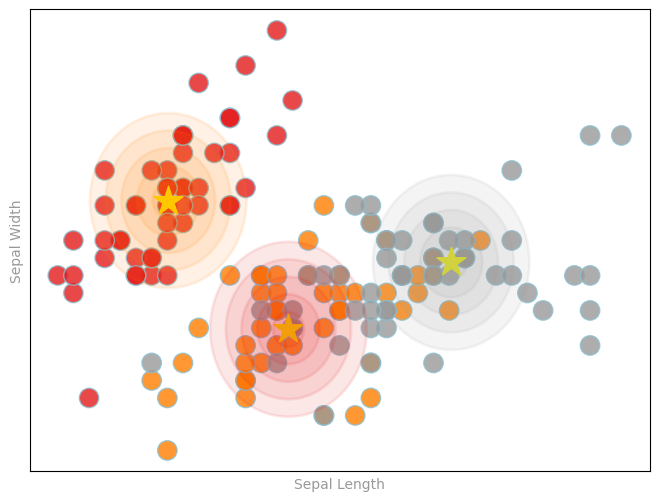

In [83]:
import matplotlib 

data = irisTwoFeaturesDF.select("features", "label").collect()
features, labels = zip(*data)

x, y = zip(*features)
centers = modelCenters[5]
centroidX, centroidY = zip(*centers)
colorMap = 'Set1'  # was 'Set2', 'Set1', 'Dark2', 'winter'

fig, ax = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(8,6))
plt.scatter(x, y, s=14**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap)
plt.scatter(centroidX, centroidY, s=22**2, marker='*', c='yellow')
cmap = matplotlib.colormaps[colorMap]

colorIndex = [.5, .99, .0]
for i, (x,y) in enumerate(centers):
    print(cmap(colorIndex[i]))
    for size in [.10, .20, .30, .40, .50]:
        circle1=plt.Circle((x,y),size,color=cmap(colorIndex[i]), alpha=.10, linewidth=2)
        ax.add_artist(circle1)

ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width')
fig.show()

In addition to seeing the overlay of the clusters at each iteration, we can see how the cluster centers moved with each iteration (and what our results would have looked like if we used fewer iterations).

(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


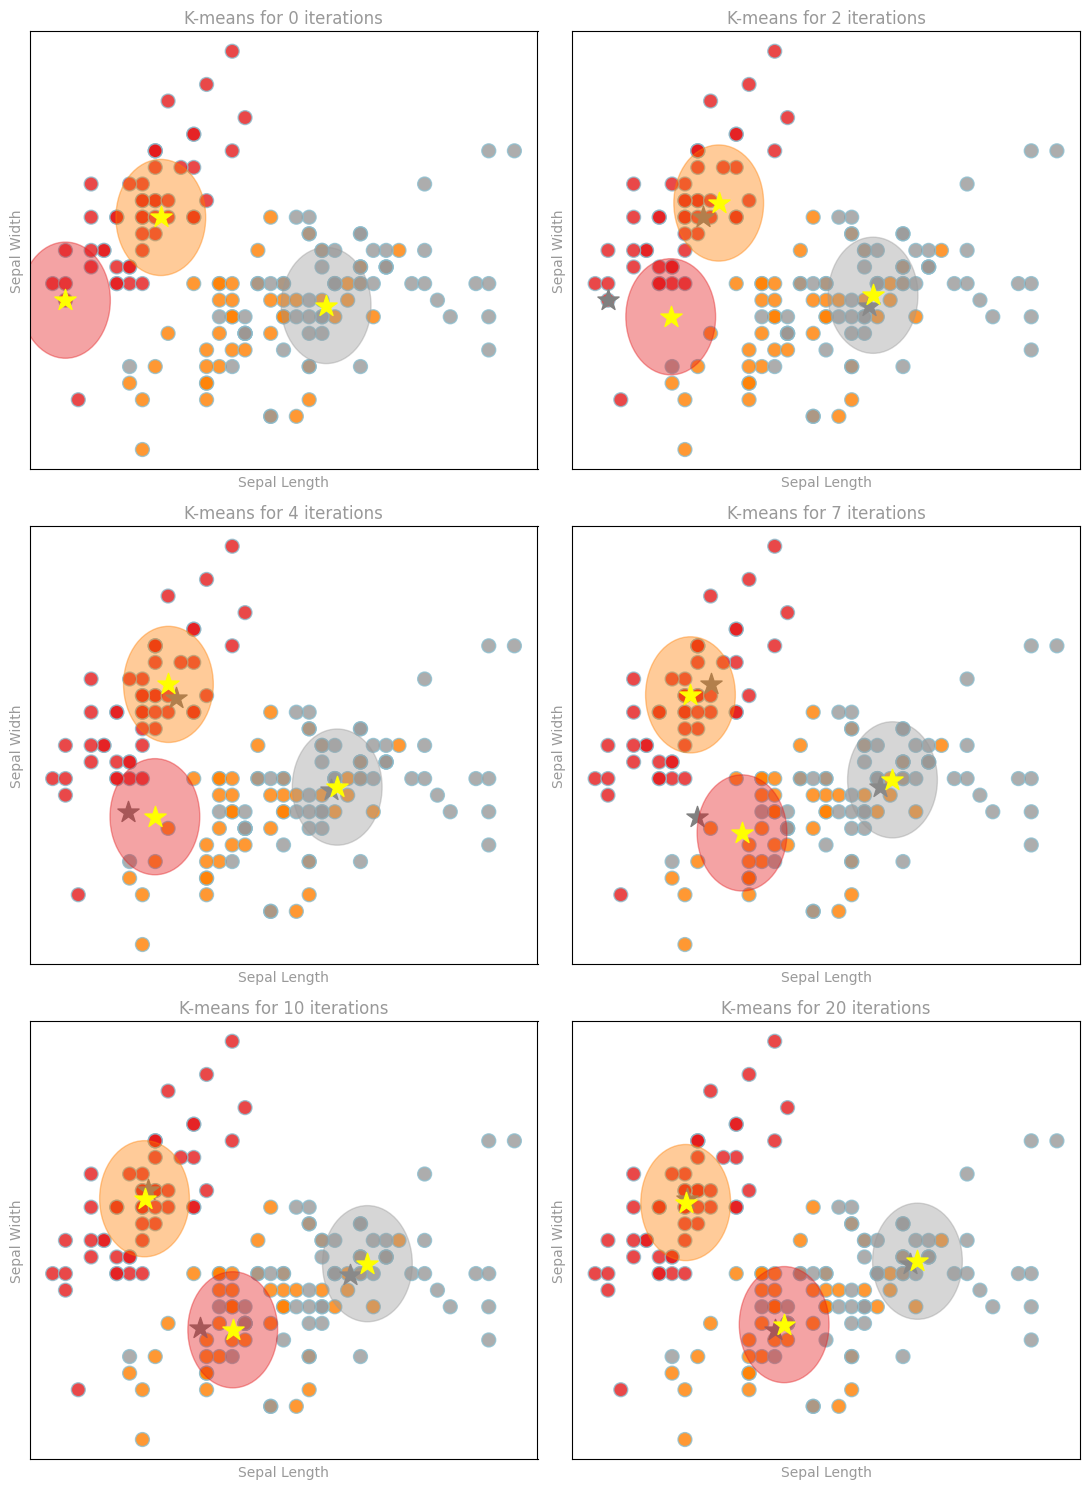

In [84]:
x, y = zip(*features)

oldCentroidX, oldCentroidY = None, None

fig, axList = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(11, 15),
                             subplots=(3, 2))
axList = axList.flatten()

for i,ax in enumerate(axList[:]):
    ax.set_title('K-means for {0} iterations'.format(iterations[i]), color='#999999')
    centroids = modelCenters[i]
    centroidX, centroidY = zip(*centroids)
    
    ax.scatter(x, y, s=10**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap, zorder=0)
    ax.scatter(centroidX, centroidY, s=16**2, marker='*', c='yellow', zorder=2)
    if oldCentroidX and oldCentroidY:
      ax.scatter(oldCentroidX, oldCentroidY, s=16**2, marker='*', c='grey', zorder=1)
    cmap = matplotlib.colormaps[colorMap]
    
    colorIndex = [.5, .99, 0.]
    for i, (x1,y1) in enumerate(centroids):
      print(cmap(colorIndex[i]))
      circle1=plt.Circle((x1,y1),.35,color=cmap(colorIndex[i]), alpha=.40)
      ax.add_artist(circle1)
    
    ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width')
    oldCentroidX, oldCentroidY = centroidX, centroidY

plt.tight_layout()

fig.show()

-----

## So let's take a look at what's happening here in the distributed setting.

<img src="https://files.training.databricks.com/images/Mapstage.png" width =500px>

<img src="https://files.training.databricks.com/images/Mapstage2.png" width =500px>

<img src="https://files.training.databricks.com/images/ReduceStage.png" width =500px>

<img src="https://files.training.databricks.com/images/Communication.png" width =500px>

## Take Aways

When designing/choosing distributed ML algorithms
* Communication is key!
* Consider your data/model dimensions & how much data you need.
* Data partitioning/organization is important.


-----

# Further Reading

* [MLflow tutorial](https://mlflow.org/docs/latest/getting-started/index.html)
* [Wandb tutorial](https://docs.wandb.ai/tutorials)


----

# END

Thank you